In [29]:
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.feature_selection import SelectKBest, f_classif
import marsilea as ma
import marsilea.plotter as mp
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from marsilea.plotter import Colors, Title
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import Normalize

sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW_v10.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
z = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

In [30]:
patients_full = '../../Utils/Lists/grouped.txt'
with open(patients_full, 'r') as file:
    patients_full = file.readlines()
patients_full = [line.strip() for line in patients_full]

In [31]:
def process_data(path, patient_list_path, suffix):
    with open(patient_list_path, 'r') as file:
        patients_full = [line.strip() for line in file.readlines()]
    
    data = hc_data.get_subset(patients_full, df=hc_data.filter_locations(path))
    data = data[[col for col in data.columns if ':' in col or (suffix == '_SCREEN' and col == "Treatment Response") or (suffix == '_SCREEN' and col == "Stratification")]]
    data = data.reset_index(drop=True)
    data.columns = [f"{col}{suffix}" for col in data.columns]
    return data

path = 'F3A.Differential_rMDS.bed'
data_sources = [
    ('../../Utils/Lists/screen_grouped.txt', '_SCREEN'),
    ('../../Utils/Lists/day0_grouped.txt', '_DAY0'),
    ('../../Utils/Lists/adjwk1_grouped.txt', '_ADJWK1')
]

processed_data = [process_data(path, p[0], p[1]) for p in data_sources]
DATA = pd.concat(processed_data, axis=1)

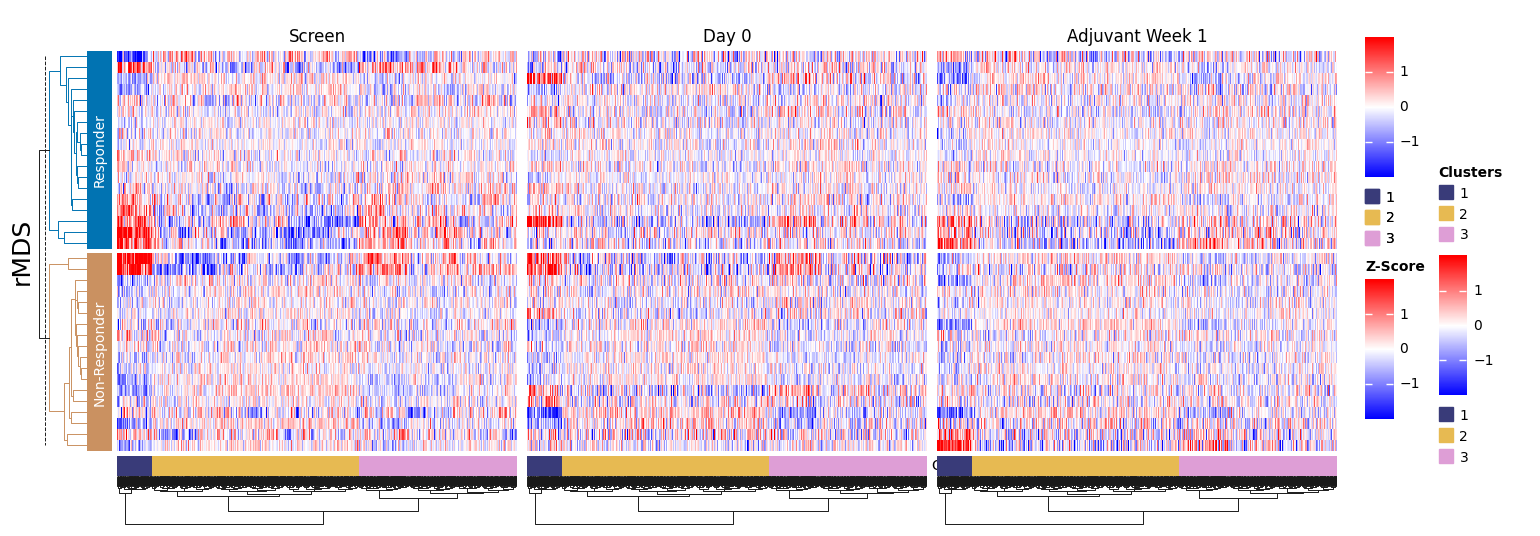

In [32]:
df = DATA

screen_data = df.filter(like='_SCREEN')
day0_data = df.filter(like='_DAY0')
adjwk1_data = df.filter(like='_ADJWK1')

screen_data.columns = [col.replace('_SCREEN', '') for col in screen_data.columns]
day0_data.columns = [col.replace('_DAY0', '') for col in day0_data.columns]
adjwk1_data.columns = [col.replace('_ADJWK1', '') for col in adjwk1_data.columns]

treatment_response = screen_data['Treatment Response']
stratification = screen_data['Stratification']
screen_data = screen_data.filter(like=':')
day0_data = day0_data.filter(like=':')
adjwk1_data = adjwk1_data.filter(like=':')

combined_data = pd.concat([screen_data, day0_data, adjwk1_data], axis=1)

colors = sns.color_palette('colorblind', 10)
treatment_palette = [colors[0], colors[5]]
response_colors = pd.Series(treatment_response).map(dict(zip(treatment_response.unique(), treatment_palette)))

responder_data = combined_data[treatment_response == 'Responder']
non_responder_data = combined_data[treatment_response == 'Non-Responder']

responder_linkage = linkage(responder_data, method='ward')
non_responder_linkage = linkage(non_responder_data, method='ward')

row_Z = {
    'Responder': responder_linkage,
    'Non-Responder': non_responder_linkage
}

link_col = pd.concat([screen_data, day0_data, adjwk1_data], axis=0)
col_Z = linkage(screen_data.T, method='ward')
col_order = dendrogram(col_Z, no_plot=True)['leaves']
clusters = fcluster(col_Z, t=3, criterion='maxclust')

h1 = ma.Heatmap(screen_data, cmap="bwr", vmax=2, vmin=-2)
h1.group_rows(treatment_response, order=["Responder", "Non-Responder"])
h1.add_left(mp.Chunk(["Responder", "Non-Responder"], treatment_palette), pad=0.05)
h1.add_dendrogram("left", colors=treatment_palette, linkage=row_Z)
color = Colors(clusters, cmap='tab20b')
h1.add_bottom(color, size=0.2, pad=0.05)
h1.add_dendrogram("bottom", linkage=col_Z)
title = Title(f"rMDS", align='center', fontsize=18)
h1.add_left(title, size=0.2, pad=0.05)
h1.add_legends()
h1.add_title(top="Screen")

h2 = ma.Heatmap(day0_data, cmap="bwr", vmax=2, vmin=-2, label="Z-Score")
h2.group_rows(treatment_response, order=["Responder", "Non-Responder"])
h2.add_dendrogram("left", colors=treatment_palette, linkage=row_Z, show=False)
color = Colors(clusters, label="Clusters", cmap='tab20b')
h2.add_bottom(color, size=0.2, pad=0.05)
h2.add_dendrogram("bottom", linkage=col_Z)
h2.add_title(top="Day 0")

h3 = ma.Heatmap(adjwk1_data, cmap="bwr", vmax=2, vmin=-2)
h3.group_rows(treatment_response, order=["Responder", "Non-Responder"])
color = Colors(stratification, label="Risk\nStratification", cmap='tab20')
color = Colors(clusters, cmap='tab20b')
h3.add_bottom(color, size=0.2, pad=0.05)
h3.add_dendrogram("left", colors=treatment_palette, linkage=row_Z, show=False)
h3.add_dendrogram("bottom", linkage=col_Z, )
h3.add_title(top="Adjuvant Week 1")

c = (h1 + .1 + h2 + .1 + h3)
c.add_legends()
c.render()

c.save('F3B.rMDS.pdf', dpi=600)

In [34]:
for cluster_num in [1, 2, 3]:
    screen_data_cluster = screen_data.iloc[:, clusters == cluster_num]
    day0_data_cluster = day0_data.iloc[:, clusters == cluster_num]
    adjwk1_data_cluster = adjwk1_data.iloc[:, clusters == cluster_num]

    parsed_data = [[
        column.split(':')[0],
        int(column.split(':')[1].split('-')[0]),
        int(column.split(':')[1].split('-')[1])
    ] for column in adjwk1_data_cluster.columns]
    
    df = pd.DataFrame(parsed_data)
    df.to_csv(f'../../Supplementary_Tables/ST3/rMDS_cluster{cluster_num}.tsv', sep='\t', index=False, header=False)
    
    combined_data = pd.concat(
        [screen_data_cluster.mean(axis=1),
         day0_data_cluster.mean(axis=1),
         adjwk1_data_cluster.mean(axis=1),
         treatment_response],
        axis=1
    )
    combined_data.columns = ['Screen', 'Day 0', 'Adjuvant Week 1', 'Treatment Response']
    combined_data['Treatment Response'] = combined_data['Treatment Response'].astype('category')

    combined_data_melted = combined_data.reset_index().melt(
        id_vars=['Treatment Response'],
        value_vars=['Screen', 'Day 0', 'Adjuvant Week 1'],
        var_name='Timepoint',
        value_name='Value'
    )

    colors = sns.color_palette('colorblind', 10)
    treatment_palette = [colors[0], colors[5]]
    hue_order = ['Responder', 'Non-Responder']

    plt.figure(figsize=(4, 4), dpi=300)
    sns.lineplot(
        data=combined_data_melted,
        x='Timepoint', y='Value', hue='Treatment Response',
        marker='o', estimator='mean', ci=95,
        palette=treatment_palette, hue_order=hue_order
    )

    plt.xlabel('Blood Sample Timepoint')
    plt.ylabel("Mean Z-Score Across\nCluster's Genomic Bins")
    plt.title(f'Cluster {cluster_num}')
    plt.xticks(ticks=[0, 1, 2], labels=['Screen', 'Day 0', 'Adjuvant\nWeek 1'])

    if cluster_num == 1:
        plt.ylim(-0.5, 0.75)
        plt.yticks(ticks=[-0.5, -0.25, 0, 0.25, 0.5, 0.75])
    else:
        plt.ylim(-0.25, 0.25)
        plt.yticks(ticks=[-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

    plt.legend(title=None, loc='upper right', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f'F3B.rMDS.C{cluster_num}.pdf', dpi=600)
    plt.close()

In [15]:
chrom_sizes = {}
with open('hg38.chrom.sizes') as f:
    for line in f:
        chrom, size = line.strip().split('\t')
        chrom_sizes[chrom] = int(size)

for cluster_num in [1, 2, 3]:
    input_file = f'../../Supplementary_Tables/ST3/rMDS_cluster{cluster_num}.tsv'
    output_file = f'./rMDS_cluster{cluster_num}.min_distance.tsv'
    
    df = pd.read_csv(input_file, sep='\t', header=None, names=['chrom', 'start', 'end'])
    
    df['midpoint'] = (df['start'] + df['end']) // 2
    df['chrom_size'] = df['chrom'].map(chrom_sizes)
    
    df['distance_to_start'] = df['midpoint']
    df['distance_to_end'] = df['chrom_size'] - df['midpoint']
    
    df['min_distance'] = df[['distance_to_start', 'distance_to_end']].min(axis=1)
    
    df['min_distance'].to_csv(output_file, sep='\t', index=False, header=False)
    
    print(f"Saved min distances for cluster {cluster_num} to {output_file}")

null_distances = []

for i in range(100000):
    chrom = random.choice(list(chrom_sizes.keys()))
    chrom_size = chrom_sizes[chrom]
    
    start = random.randint(0, chrom_size - 500_000)
    end = start + 500_000
    midpoint = (start + end) // 2
    
    distance_to_start = midpoint
    distance_to_end = chrom_size - midpoint
    min_distance = min(distance_to_start, distance_to_end)
    
    null_distances.append(min_distance)

null_output_file = './null_min_distance.tsv'
pd.Series(null_distances).to_csv(null_output_file, sep='\t', index=False, header=False)

print(f"Saved null distribution to {null_output_file}")

Saved min distances for cluster 1 to ./rMDS_cluster1.min_distance.tsv
Saved min distances for cluster 2 to ./rMDS_cluster2.min_distance.tsv
Saved min distances for cluster 3 to ./rMDS_cluster3.min_distance.tsv
Saved null distribution to ./null_min_distance.tsv


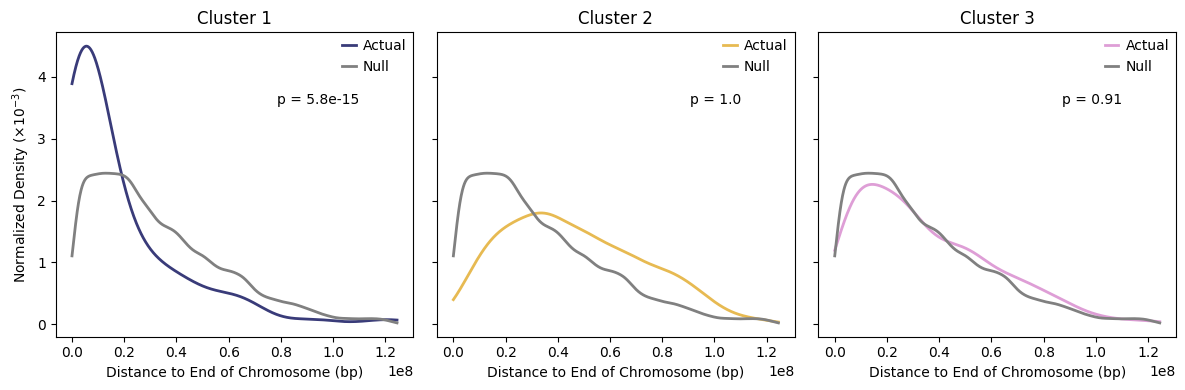

In [16]:
import scipy.stats as stats
import numpy as np

null_distances = pd.read_csv('./null_min_distance.tsv', sep='\t', header=None)[0]
null_distances = null_distances[null_distances >= 0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

colors = {1: '#393B79', 2: '#e7ba52', 3: '#de9ed6'}

for idx, cluster_num in enumerate([1, 2, 3]):
    actual_distances = pd.read_csv(f'./rMDS_cluster{cluster_num}.min_distance.tsv', sep='\t', header=None)[0]
    actual_distances = actual_distances[actual_distances >= 0]
    
    ax = axes[idx]
    
    xmin = 0
    xmax = max(null_distances.max(), actual_distances.max())
    x_values = np.linspace(xmin, xmax, 1000)
    
    actual_kde = stats.gaussian_kde(actual_distances)
    actual_density = actual_kde(x_values)
    
    null_kde = stats.gaussian_kde(null_distances)
    null_density = null_kde(x_values)
    
    actual_density /= actual_density.sum()
    null_density /= null_density.sum()
    
    ax.plot(x_values, actual_density * 1e3, label='Actual', color=colors[cluster_num], linewidth=2)
    ax.plot(x_values, null_density * 1e3, label='Null', color='gray', linewidth=2)
    
    ax.set_title(f'Cluster {cluster_num}')
    ax.set_xlabel('Distance to End of Chromosome (bp)')
    if idx == 0:
        ax.set_ylabel('Normalized Density ($\\times 10^{-3}$)')
    
    stat, p_value = stats.mannwhitneyu(actual_distances, null_distances, alternative='less')
    
    ax.text(0.85, 0.80, f'p = {p_value:.2}', transform=ax.transAxes,
            ha='right', va='top', fontsize=10)
    ax.legend()

plt.tight_layout()
plt.savefig('F3B.rMDS.P3.pdf')
plt.show()

In [17]:
from tqdm import tqdm
from scipy.stats import mannwhitneyu
random.seed(42)
np.random.seed(42)

chrom_sizes = {}
with open('hg38.chrom.sizes') as f:
    for line in f:
        chrom, size = line.strip().split('\t')
        chrom_sizes[chrom] = int(size)

interval_size = 500_000
sample_size = 360
n_iterations = 100_000

cluster_means = {}
cluster_min_distances = {}

for cluster_num in [1, 2, 3]:
    input_file = f'../../Supplementary_Tables/ST3/rMDS_cluster{cluster_num}.tsv'
    df = pd.read_csv(input_file, sep='\t', header=None, names=['chrom', 'start', 'end'])
    df['midpoint'] = (df['start'] + df['end']) // 2
    df['chrom_size'] = df['chrom'].map(chrom_sizes)
    df['distance_to_start'] = df['midpoint']
    df['distance_to_end'] = df['chrom_size'] - df['midpoint']
    df['min_distance'] = df[['distance_to_start', 'distance_to_end']].min(axis=1)
    
    cluster_min_distances[cluster_num] = df['min_distance'].values
    mean_min_distance = df['min_distance'].median()
    cluster_means[cluster_num] = mean_min_distance
    
    print(f"Cluster {cluster_num} mean min distance: {mean_min_distance:.2f}")

null_mean_distances = []

chrom_list = list(chrom_sizes.keys())

for _ in tqdm(range(n_iterations), desc="Generating null distribution"):
    sample_min_distances = []
    while len(sample_min_distances) < sample_size:
        chrom = random.choice(chrom_list)
        chrom_size = chrom_sizes[chrom]
        if chrom_size <= interval_size:
            continue
        start = random.randint(0, chrom_size - interval_size)
        end = start + interval_size
        midpoint = (start + end) // 2
        
        distance_to_start = midpoint
        distance_to_end = chrom_size - midpoint
        min_distance = min(distance_to_start, distance_to_end)
        
        sample_min_distances.append(min_distance)
    
    mean_distance = np.median(sample_min_distances)
    null_mean_distances.append(mean_distance)

null_mean_distances = np.array(null_mean_distances)

Cluster 1 mean min distance: 7568468.00
Cluster 2 mean min distance: 42788259.00
Cluster 3 mean min distance: 28308808.00


Generating null distribution: 100%|██████████| 100000/100000 [00:57<00:00, 1731.48it/s]


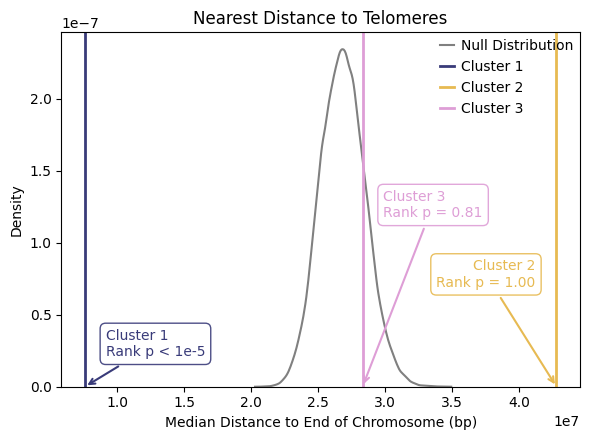

In [19]:
plt.figure(figsize=(4*1.5, 3*1.5))

sns.kdeplot(null_mean_distances, color='gray', label='Null Distribution')

colors = {1: '#393B79', 2: '#e7ba52', 3: '#de9ed6'}

for cluster_num, mean_val in cluster_means.items():
    plt.axvline(mean_val, color=colors[cluster_num], linestyle='-', linewidth=2, label=f'Cluster {cluster_num}')

ylim = plt.ylim()
xlim = plt.xlim()

y_offset_start = 20
y_offset_step = 50

for idx, (cluster_num, mean_val) in enumerate(cluster_means.items()):
    rank_p = np.mean(null_mean_distances <= mean_val)

    if mean_val > (xlim[0] + 0.75 * (xlim[1] - xlim[0])):
        x_offset = -15
        ha = 'right'
    else:
        x_offset = 15
        ha = 'left'

    xy = (mean_val, 0)
    xytext = (x_offset, y_offset_start + idx * y_offset_step)

    if rank_p < 1e-5:
        annotation_text = (f'Cluster {cluster_num}\n'
                           f'Rank p < 1e-5')
    else:
        annotation_text = (f'Cluster {cluster_num}\n'
                           f'Rank p = {rank_p:.2f}')

    plt.annotate(annotation_text, 
                 xy=xy, xycoords='data',
                 xytext=xytext, textcoords='offset points',
                 ha=ha, va='bottom',
                 color=colors[cluster_num], fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor=colors[cluster_num], alpha=0.9),
                 arrowprops=dict(arrowstyle='->', color=colors[cluster_num], lw=1.5))
plt.title('Nearest Distance to Telomeres')
plt.xlabel('Median Distance to End of Chromosome (bp)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('F3B.rMDS.P4.pdf')
plt.show()


In [20]:
import pandas as pd

cent_df = pd.read_csv(
    "UCSC.centromeres.20250616.hg38.txt",
    sep="\t",
    header=None,
    names=["bin", "chrom", "start", "end", "name"]
)

cent_df["start"] = pd.to_numeric(cent_df["start"], errors="coerce")
cent_df["end"] = pd.to_numeric(cent_df["end"], errors="coerce")

cent_df = cent_df.dropna(subset=["start", "end"])
cent_df = cent_df[~cent_df['chrom'].isin(['chrX', 'chrY'])]
centromere_midpoints = (
    cent_df
    .groupby("chrom")
    .agg(start_min=("start", "min"), end_max=("end", "max"))
    .assign(midpoint=lambda x: (x.start_min + x.end_max) // 2)
    .midpoint
    .to_dict()
)

for cluster_num in [1, 2, 3]:
    input_file = f'../../Supplementary_Tables/ST3/rMDS_cluster{cluster_num}.tsv'
    output_file = f'./rMDS_cluster{cluster_num}.centromere_distance.tsv'
    
    df = pd.read_csv(input_file, sep='\t', header=None, names=['chrom', 'start', 'end'])
    
    df['midpoint'] = (df['start'] + df['end']) // 2
    df['centromere_midpoint'] = df['chrom'].map(centromere_midpoints)
    
    df['distance_to_centromere'] = (df['midpoint'] - df['centromere_midpoint']).abs()
    
    df['distance_to_centromere'].to_csv(output_file, sep='\t', index=False, header=False)
    
    print(f"Saved centromere distances for cluster {cluster_num} to {output_file}")

null_distances = []

valid_chroms = list(set(chrom_sizes.keys()) & set(centromere_midpoints.keys()))

for i in range(100000):
    chrom = random.choice(valid_chroms)
    chrom_size = chrom_sizes[chrom]
    centromere_mid = centromere_midpoints[chrom]
    
    start = random.randint(0, chrom_size - 500_000)
    end = start + 500_000
    midpoint = (start + end) // 2
    
    distance_to_centromere = abs(midpoint - centromere_mid)
    
    null_distances.append(distance_to_centromere)

null_output_file = './null_centromere_distance.tsv'
pd.Series(null_distances).to_csv(null_output_file, sep='\t', index=False, header=False)

print(f"Saved null distribution to {null_output_file}")

Saved centromere distances for cluster 1 to ./rMDS_cluster1.centromere_distance.tsv
Saved centromere distances for cluster 2 to ./rMDS_cluster2.centromere_distance.tsv
Saved centromere distances for cluster 3 to ./rMDS_cluster3.centromere_distance.tsv
Saved null distribution to ./null_centromere_distance.tsv


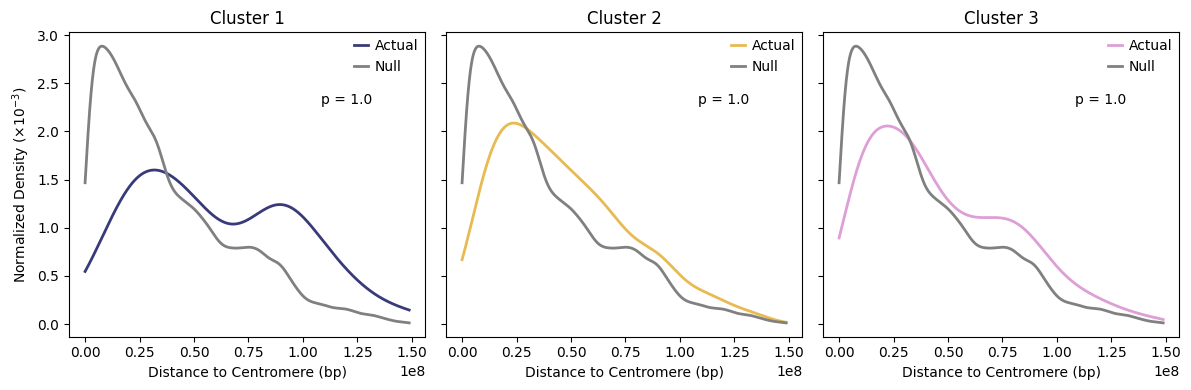

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

null_distances = pd.read_csv('./null_centromere_distance.tsv', sep='\t', header=None)[0]
null_distances = null_distances[null_distances >= 0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

colors = {1: '#393B79', 2: '#e7ba52', 3: '#de9ed6'}

for idx, cluster_num in enumerate([1, 2, 3]):
    actual_distances = pd.read_csv(f'./rMDS_cluster{cluster_num}.centromere_distance.tsv', sep='\t', header=None)[0]
    actual_distances = actual_distances[actual_distances >= 0]
    
    ax = axes[idx]
    
    xmin = 0
    xmax = max(null_distances.max(), actual_distances.max())
    x_values = np.linspace(xmin, xmax, 1000)
    
    actual_kde = stats.gaussian_kde(actual_distances)
    actual_density = actual_kde(x_values)
    
    null_kde = stats.gaussian_kde(null_distances)
    null_density = null_kde(x_values)
    
    actual_density /= actual_density.sum()
    null_density /= null_density.sum()
    
    ax.plot(x_values, actual_density * 1e3, label='Actual', color=colors[cluster_num], linewidth=2)
    ax.plot(x_values, null_density * 1e3, label='Null', color='gray', linewidth=2)
    
    ax.set_title(f'Cluster {cluster_num}')
    ax.set_xlabel('Distance to Centromere (bp)')
    if idx == 0:
        ax.set_ylabel('Normalized Density ($\\times 10^{-3}$)')
    
    stat, p_value = stats.mannwhitneyu(actual_distances, null_distances, alternative='less')
    
    ax.text(0.85, 0.80, f'p = {p_value:.2}', transform=ax.transAxes,
            ha='right', va='top', fontsize=10)
    ax.legend()

plt.tight_layout()
plt.savefig('F3B.rMDS.P5.pdf')
plt.show()


In [22]:
random.seed(42)
np.random.seed(42)

chrom_sizes = {}
with open('hg38.chrom.sizes') as f:
    for line in f:
        chrom, size = line.strip().split('\t')
        chrom_sizes[chrom] = int(size)

cent_df = pd.read_csv(
    "UCSC.centromeres.20250616.hg38.txt",
    sep="\t",
    header=None,
    names=["bin", "chrom", "start", "end", "name"]
)
cent_df["start"] = pd.to_numeric(cent_df["start"], errors="coerce")
cent_df["end"] = pd.to_numeric(cent_df["end"], errors="coerce")
cent_df = cent_df.dropna(subset=["start", "end"])
cent_df = cent_df[~cent_df['chrom'].isin(['chrX', 'chrY'])]
centromere_midpoints = (
    cent_df
    .groupby("chrom")
    .agg(start_min=("start", "min"), end_max=("end", "max"))
    .assign(midpoint=lambda x: (x.start_min + x.end_max) // 2)
    .midpoint
    .to_dict()
)

interval_size = 500_000
sample_size = 360
n_iterations = 100_000

valid_chroms = list(set(chrom_sizes.keys()) & set(centromere_midpoints.keys()))

cluster_means = {}
for cluster_num in [1, 2, 3]:
    input_file = f'../../Supplementary_Tables/ST3/rMDS_cluster{cluster_num}.tsv'
    df = pd.read_csv(input_file, sep='\t', header=None, names=['chrom', 'start', 'end'])
    df['midpoint'] = (df['start'] + df['end']) // 2
    df['chrom_size'] = df['chrom'].map(chrom_sizes)
    df['centromere_midpoint'] = df['chrom'].map(centromere_midpoints)
    df['distance_to_centromere'] = (df['midpoint'] - df['centromere_midpoint']).abs()
    
    mean_dist = df['distance_to_centromere'].median()
    cluster_means[cluster_num] = mean_dist
    
    print(f"Cluster {cluster_num} mean distance to centromere: {mean_dist:.2f}")

null_mean_distances = []

for _ in tqdm(range(n_iterations)):
    sample_distances = []
    while len(sample_distances) < sample_size:
        chrom = random.choice(valid_chroms)
        chrom_size = chrom_sizes[chrom]
        if chrom_size <= interval_size:
            continue
        
        centromere_mid = centromere_midpoints[chrom]
        start = random.randint(0, chrom_size - interval_size)
        end = start + interval_size
        midpoint = (start + end) // 2
        
        dist = abs(midpoint - centromere_mid)
        sample_distances.append(dist)
    
    null_mean_distances.append(np.median(sample_distances))

null_mean_distances = np.array(null_mean_distances)

Cluster 1 mean distance to centromere: 51461587.00
Cluster 2 mean distance to centromere: 41204096.00
Cluster 3 mean distance to centromere: 38776670.00


100%|██████████| 100000/100000 [00:56<00:00, 1782.00it/s]


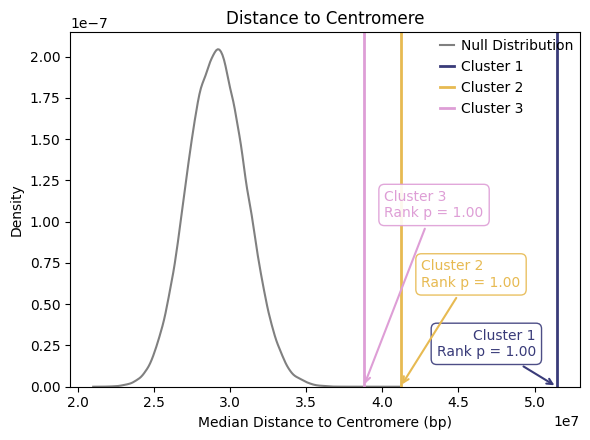

In [24]:
plt.figure(figsize=(4*1.5, 3*1.5))

sns.kdeplot(null_mean_distances, color='gray', label='Null Distribution')

colors = {1: '#393B79', 2: '#e7ba52', 3: '#de9ed6'}

for cluster_num, mean_val in cluster_means.items():
    plt.axvline(mean_val, color=colors[cluster_num], linestyle='-', linewidth=2, label=f'Cluster {cluster_num}')

ylim = plt.ylim()
xlim = plt.xlim()

y_offset_start = 20
y_offset_step = 50

for idx, (cluster_num, mean_val) in enumerate(cluster_means.items()):
    rank_p = np.mean(null_mean_distances <= mean_val)

    if mean_val > (xlim[0] + 0.75 * (xlim[1] - xlim[0])):
        x_offset = -15
        ha = 'right'
    else:
        x_offset = 15
        ha = 'left'

    xy = (mean_val, 0)
    xytext = (x_offset, y_offset_start + idx * y_offset_step)

    if rank_p < 1e-5:
        annotation_text = (f'Cluster {cluster_num}\n'
                           f'Rank p < 1e-5')
    else:
        annotation_text = (f'Cluster {cluster_num}\n'
                           f'Rank p = {rank_p:.2f}')

    plt.annotate(annotation_text, 
                 xy=xy, xycoords='data',
                 xytext=xytext, textcoords='offset points',
                 ha=ha, va='bottom',
                 color=colors[cluster_num], fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor=colors[cluster_num], alpha=0.9),
                 arrowprops=dict(arrowstyle='->', color=colors[cluster_num], lw=1.5))
plt.title('Distance to Centromere')
plt.xlabel('Median Distance to Centromere (bp)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('F3B.rMDS.P6.pdf')
plt.show()
